<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). [mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2021

## <center>Assignment #6. Task</center><a class="tocSkip">
### <center> Beating benchmarks in "How good is your Medium article?"</center><a class="tocSkip">
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline" (~1.45 Public LB score). You can refer to [this simple Ridge baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline?rvi=1).

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_eng__, pinned thread __#a6_bonus__. If you are sure that something is not 100% correct, please leave your feedback there*

-----

# Imports

In [106]:
# !pip install xgboost nltk dill optuna lightgbm

In [1]:
import json
import os
import pickle
from collections import defaultdict
from functools import partial
from html.parser import HTMLParser
from pathlib import Path

import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
import optuna
import optuna.integration.lightgbm as lgb
import pandas as pd
from nltk import TweetTokenizer
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm

# Params

In [2]:
SEED = 42
PATH_TO_DATA = "data"
PATH_TO_SAVE_DIR = "prepared_data"

# Cleaning HTML

The following code will help to throw away all HTML tags from an article content.

In [3]:
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return "".join(self.fed)


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# Reading JSON

Supplementary function to read a JSON line without crashing on escape characters.

In [5]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(" ")[-1].replace(")", ""))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = " "
        new_line = "".join(new_line)
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [6]:
def check_file(filename):
    file = Path(filename)
    return file.is_file()

In [7]:
def read_from_disk(features, path_to_save, prefix):
    reload_files = False
    d = defaultdict()
    for feature in features:
        filename = os.path.join(path_to_save, prefix + "_" + feature + ".txt")
        if check_file(filename):
            print(f"Reading from disk {filename}")
            with open(filename, "rb") as fp:
                d[feature] = pickle.load(fp)
        else:
            reload_files = True

    return reload_files, d

In [8]:
def extract_features_and_write(path_to_data, path_to_save, inp_filename, is_train=True):
    titles = []
    contents = []
    dates = []

    authors = []
    features = ["content", "published", "title", "author"]
    prefix = "train" if is_train else "test"

    Path(path_to_save).mkdir(parents=True, exist_ok=True)

    reload_files, d = read_from_disk(features, path_to_save, prefix)

    if reload_files:

        feature_files = [
            open(os.path.join(path_to_save, "{}_{}.txt".format(prefix, feat)), "w", encoding="utf-8")
            for feat in features
        ]

        with open(os.path.join(path_to_data, inp_filename), encoding="utf-8") as inp_json_file:

            for line in tqdm(inp_json_file, desc=f"Reading {prefix} json files"):
                json_data = read_json_line(line)

                title = json_data["title"].replace("\n", " ").replace("\t", " ").replace("\r", " ").replace("\xa0", " ")
                content = strip_tags(
                    json_data["content"].replace("\n", " ").replace("\t", " ").replace("\r", " ").replace("\xa0", " ")
                )
                published = json_data["published"]
                author = json_data["meta_tags"]["author"]
                authors_name = json_data["meta_tags"]["author"]

                titles.append(title)
                contents.append(content)
                dates.append(published)
                authors.append(authors_name)

        d = {"content": contents, "published": dates, "title": titles, "author": authors}
        for feature in features:
            filename = prefix + "_" + feature + ".txt"
            with open(os.path.join(path_to_save, filename), "wb") as fp:
                pickle.dump(d[feature], fp)
    else:
        titles, contents, dates, authors = d["title"], d["content"], d["published"], d["author"]

    return titles, contents, dates, authors

Download the [competition data](https://www.kaggle.com/c/how-good-is-your-medium-article/data) and place it where it's convenient for you. You can modify the path to data below.

In [9]:
train_titles, train_contents, train_dates, train_authors = extract_features_and_write(
    PATH_TO_DATA, PATH_TO_SAVE_DIR, "train.json", is_train=True
)
test_titles, test_contents, test_dates, test_authors = extract_features_and_write(
    PATH_TO_DATA, PATH_TO_SAVE_DIR, "test.json", is_train=False
)

Reading from disk prepared_data\train_content.txt
Reading from disk prepared_data\train_published.txt
Reading from disk prepared_data\train_title.txt
Reading from disk prepared_data\train_author.txt
Reading from disk prepared_data\test_content.txt
Reading from disk prepared_data\test_published.txt
Reading from disk prepared_data\test_title.txt
Reading from disk prepared_data\test_author.txt


# Feature engineering

**Add the following groups of features:**
* Tf-Idf with article content:
  * ngram_range=(1, 2)
  * max_features=100000
* Tf-Idf with article titles:
  * ngram_range=(1, 2)
  * max_features=100000
* Time features: 
  * publication hour, 
  * time of the day 
  * weekend or not
* Bag of authors  
i.e. One-Hot-Encoded author names

In [42]:
TITLE_NGRAMS = (1, 2)  # for tf-idf on titles
CONTENT_NGRAMS = (1, 2)  # for tf-idf on contents
MAX_FEATURES = 100_000  # for tf-idf

## Tokenizer

In [10]:
tokenizer = TweetTokenizer()
assert tokenizer.tokenize("Now I'm a man") == ["Now", "I'm", "a", "man"]

In [11]:
def tokenize(text):
    return tokenizer.tokenize(text)

## Doing TF-IDF vectorization for articles

In [12]:
art_vec_params = {
    "ngram_range": CONTENT_NGRAMS,
    "max_features": MAX_FEATURES,
    "tokenizer": tokenize,
    "stop_words": ENGLISH_STOP_WORDS,
}

In [13]:
article_vectorizer_params_str = f"{art_vec_params['ngram_range']}_{art_vec_params['max_features']}"
article_vec_name = f"vectorizer_article_{article_vectorizer_params_str}.pickle"

In [14]:
%%time
article_vec_is_saved = check_file(article_vec_name)
if article_vec_is_saved:
    vectorizer_article = pickle.load(open(article_vec_name, "rb"))
else:
    vectorizer_article = TfidfVectorizer(**article_vectorizer_params)
    vectorizer_article.fit(train_contents)
    pickle.dump(vectorizer_article, open(article_vec_name, "wb"))

X_train_article = vectorizer_article.transform(train_contents)
X_test_article = vectorizer_article.transform(test_contents)

CPU times: total: 12min 25s
Wall time: 12min 26s


## Doing TF-IDF vectorization for titles

In [15]:
title_vec_params = {
    "ngram_range": TITLE_NGRAMS,
    "max_features": MAX_FEATURES,
    "tokenizer": tokenize,
    "stop_words": ENGLISH_STOP_WORDS,
}

In [16]:
title_vectorizer_params_str = f"{title_vec_params['ngram_range']}_{title_vec_params['max_features']}"
title_vec_name = f"vectorizer_title_{title_vectorizer_params_str}.pickle"

In [17]:
%%time
title_vec_is_saved = check_file(title_vec_name)
if title_vec_is_saved:
    vectorizer_title = pickle.load(open(title_vec_name, "rb"))
else:
    vectorizer_title = TfidfVectorizer(**title_vec_params)
    vectorizer_title.fit(train_titles)
    pickle.dump(vectorizer_title, open(title_vec_name, "wb"))

X_train_title = vectorizer_title.transform(train_titles)
X_test_title = vectorizer_title.transform(test_titles)

CPU times: total: 6.27 s
Wall time: 6.27 s


## Preparing time features

In [18]:
# Time features
def add_time_features(dates):
    scaler = StandardScaler()
    hour = scaler.fit_transform(np.array([date.hour for date in dates]).reshape(-1, 1))
    weekday = scaler.fit_transform(np.array([date.weekday() for date in dates]).reshape(-1, 1))
    morning = scaler.fit_transform(((hour >= 7) & (hour <= 11)).astype("int").reshape(-1, 1))
    day = scaler.fit_transform(((hour >= 12) & (hour <= 18)).astype("int").reshape(-1, 1))
    evening = scaler.fit_transform(((hour >= 19) & (hour <= 23)).astype("int").reshape(-1, 1))
    night = scaler.fit_transform(((hour >= 0) & (hour <= 6)).astype("int").reshape(-1, 1))
    weekend_temp = np.array([date.weekday() for date in dates]).reshape(-1, 1)
    weekend = scaler.fit_transform(((weekend_temp >= 5) & (weekend_temp <= 6)).astype("int").reshape(-1, 1))

    feature_names = ["morning", "day", "evening", "night", "weekday"]
    time_features = pd.DataFrame(
        list(zip(morning.flatten(), day.flatten(), evening.flatten(), night.flatten(), weekend.flatten())),
        columns=feature_names,
    )
    sparse_time_features = csr_matrix(time_features.values)
    return sparse_time_features, feature_names

In [19]:
train_times = pd.to_datetime([date["$date"] for date in train_dates])
test_times = pd.to_datetime([date["$date"] for date in test_dates])

X_train_time_features_sparse, time_feature_names = add_time_features(train_times)
X_test_time_features_sparse, _ = add_time_features(test_times)

## Doing bag of authors

In [20]:
authors = np.unique(train_authors + test_authors)
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(authors.reshape(-1, 1))
enc.categories_
X_train_author_sparse = enc.transform(np.array(train_authors).reshape(-1, 1)).toarray()
X_test_author_sparse = enc.transform(np.array(test_authors).reshape(-1, 1)).toarray()

## Preparing additional features

In [21]:
train_len = [len(article) for article in train_contents]
test_len = [len(article) for article in test_contents]
scaler = StandardScaler()

X_train_len_sparse = scaler.fit_transform(np.array(train_len).reshape(-1, 1))
X_test_len_sparse = scaler.fit_transform(np.array(test_len).reshape(-1, 1))

## Joining features

**Join all sparse matrices.**

In [22]:
X_train_sparse = hstack(
    [X_train_article, X_train_title, X_train_author_sparse, X_train_time_features_sparse, X_train_len_sparse]
).tocsr()

X_test_sparse = hstack(
    [X_test_article, X_test_title, X_test_author_sparse, X_test_time_features_sparse, X_test_len_sparse]
).tocsr()

### Saving dataset for training

In [29]:
pickle.dump(X_trapickle, open("X_train_sparse.pickle", "wb"))
pickle.dump(X_test_sparse, open("X_test_sparse.pickle", "wb"))
pickle.dump(y_train, open("y_train.pickle", "wb"))

### Reading dataset from disk

In [3]:
X_train_sparse = pickle.load(open("X_train_sparse.pickle", "rb"))
X_test_sparse = pickle.load(open("X_test_sparse.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))

# Read train target and split data for validation

In [7]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, "train_log1p_recommends.csv"), index_col="id")
y_train = train_target["log_recommends"].values

In [8]:
train_part_size = int(0.7 * train_target.shape[0])

X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]

X_valid_sparse = X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

# Training

## Ridge

### Hyperparameters tuning

In [52]:
alpha_values = np.logspace(-2, 2, 40)
# alpha_values = np.logspace(0, 0.1, 40)

logit_grid_searcher = GridSearchCV(
    estimator=Ridge(random_state=SEED),
    param_grid={"alpha": alpha_values},
    scoring="neg_mean_absolute_error",
    n_jobs=6,
    cv=3,
    verbose=3,
)

logit_grid_searcher.fit(X_train_sparse, np.log1p(y_train))

print(logit_grid_searcher.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'alpha': 1.1253355826007645}


In [53]:
logit_grid_searcher.best_score_

-0.29016979593377706

{'alpha': 1.1867492730446552}

### Validation MAE

In [13]:
ridge = Ridge(random_state=SEED, alpha=1.1253355826007645)
ridge.fit(X_train_part_sparse, np.log1p(y_train_part))
ridge_valid_pred = np.expm1(ridge.predict(X_valid_sparse))
ridge_valid_mae = mean_absolute_error(y_valid, ridge_valid_pred)
ridge_valid_mae

1.0619034952860282

### Training with best hyperparameters

In [14]:
ridge = Ridge(random_state=SEED, alpha=1.1253355826007645)
ridge.fit(X_train_sparse, np.log1p(y_train))
ridge_test_pred = np.expm1(ridge.predict(X_test_sparse))

## LightGBM

https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna?scriptVersionId=94510532  
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f  
https://www.youtube.com/watch?v=5nYqK-HaoKY  
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-  

### Tuning # 1

In [7]:
from lightgbm import early_stopping, log_evaluation

data = lgb.Dataset(X_train_sparse.astype(np.float32), label=np.log1p(y_train))

params = {
    "objective": "regression_l1",
    "metric": "l1",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "device_type": "gpu",
}
tuner = lgb.LightGBMTunerCV(
    params,
    data,
    num_boost_round=5,
    folds=KFold(n_splits=3),
    callbacks=[early_stopping(10), log_evaluation(1)],
)
tuner.run()
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2022-05-15 17:31:26,335] A new study created in memory with name: no-name-c3191736-7363-4622-890c-393278331c71
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\ryblo\Documents\projects\mlcourse_ai_bonus_assignments\venv\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	cv_agg's l1: 0.406432 + 0.019252
[1]	cv_agg's l1: 0.406432 + 0.019252
Training until validation scores don't improve for 10 rounds
[2]	cv_agg's l1: 0.399635 + 0.0186409
[2]	cv_agg's l1: 0.399635 + 0.0186409
[3]	cv_agg's l1: 0.393892 + 0.0178621
[3]	cv_agg's l1: 0.393892 + 0.0178621
[4]	cv_agg's l1: 0.38884 + 0.0171225
[4]	cv_agg's l1: 0.38884 + 0.0171225
[5]	cv_agg's l1: 0.384564 + 0.0165255
[5]	cv_agg's l1: 0.384564 + 0.0165255
Did not meet early stopping. Best iteration is:
[5]	cv_agg's l1: 0.384564 + 0.0165255


feature_fraction, val_score: 0.384564:  14%|######2                                     | 1/7 [03:55<23:14, 232.42s/it]

KeyboardInterrupt: 

### Training with best hyperparameters

In [27]:
import lightgbm as lgb

lgb_x_train = lgb.Dataset(X_train_sparse.astype(np.float32), label=np.log1p(y_train))
lgb_x_valid = lgb.Dataset(X_valid_sparse.astype(np.float32), label=np.log1p(y_valid))
param = {"objective": "mean_absolute_error", "metric": "mae", "verbose": 5, "max_depth": 9}
bst_lgb = lgb.train(param, lgb_x_train, 60, verbose_eval=5, early_stopping_rounds=20, valid_sets=[lgb_x_valid])
lgb_test_pred = np.expm1(bst_lgb.predict(X_test_sparse.astype(np.float32)))

C:\Users\ryblo\Documents\projects\mlcourse_ai_bonus_assignments\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ryblo\Documents\projects\mlcourse_ai_bonus_assignments\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.993373
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.992853
[LightGBM] [Debug] init for col-wise cost 12.247353 seconds, init for row-wise cost 13.589792 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 15.266464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8541057
[LightGBM] [Info] Number of data points in the train set: 62313, number of used features: 103682
[LightGBM] [Info] Start training from score 1.291725
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
Training until validation scores don't improve for 20 rounds
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[5]	val

### Validation MAE

In [28]:
lgb_valid_pred = np.expm1(bst_lgb.predict(X_valid_sparse))
lgb_valid_mae = mean_absolute_error(y_valid, lgb_valid_pred)
lgb_valid_mae

1.242082401571958

## Simple blending

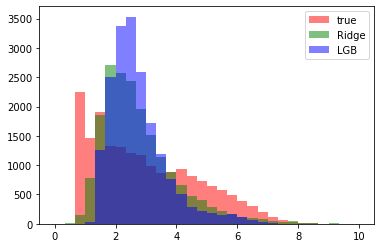

In [25]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_valid_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(lgb_valid_pred, bins=30, alpha=.5, color='blue', label='LGB', range=(0,10));
plt.legend();

In [26]:
for i in np.arange(0, 1.1, 0.1):
    print(i, mean_absolute_error(y_valid, (1 - i) * lgb_valid_pred + i * ridge_valid_pred))

0.0 1.1495727794551638
0.1 1.1254280584668486
0.2 1.1044880003415622
0.30000000000000004 1.0866146523065774
0.4 1.07196704702466
0.5 1.0606179818201866
0.6000000000000001 1.0528472219070115
0.7000000000000001 1.048980524373251
0.8 1.0490509047268561
0.9 1.0535718513461647
1.0 1.0619034952860282


## Training with all data

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [18]:
MEAN_TEST_TARGET = 4.33328  # what we got by submitting all zeros

RIDGE_WEIGHT = 0.6 # weight of Ridge predictions in a blend with XGBoost

In [19]:
mix_pred = (1 - RIDGE_WEIGHT) * lgb_test_pred + RIDGE_WEIGHT * ridge_test_pred
mix_test_pred_modif = mix_pred + MEAN_TEST_TARGET - y_train.mean()

In [20]:
def write_submission_file(
    prediction,
    filename,
    path_to_sample=os.path.join(PATH_TO_DATA, "sample_submission.csv"),
):
    submission = pd.read_csv(path_to_sample, index_col="id")

    submission["log_recommends"] = prediction
    submission.to_csv(filename)

In [21]:
write_submission_file(mix_test_pred_modif, os.path.join(PATH_TO_DATA, "assignment6_medium_submission.csv"))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeros. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [18]:
write_submission_file(
    np.zeros_like(ridge_test_pred),
    os.path.join(PATH_TO_DATA, "medium_all_zeros_submission.csv"),
)

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [19]:
ridge_test_pred_modif = ridge_test_pred
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [20]:
write_submission_file(
    ridge_test_pred_modif,
    os.path.join(PATH_TO_DATA, "assignment6_medium_submission_with_hack.csv"),
)

That's it for the assignment. In case you'd like to try some more ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will train much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- And neural nets of course. We don't cover them in this course byt still transformer-based architectures will likely perform well in such types of tasks